In [1]:
import numpy as np
from scipy.stats import norm, f, ttest_1samp, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math

In [2]:
# 1. define BS formulas for a call option pricing, which gives the owner the right to acquire the underlying security at expiry

#Standard BS formula for a call - required for pricing:
def bs_call_price(S0, K, r, sigma, tau):
    """Volatility: sigma
    The price of the underlying asset: S0
    The strike price of the option: K
    The time until the expiration of the option: tau
    The risk-free interest rate: r
    """
    tau = np.maximum(tau, 1e-12)  # avoid zero division
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S0 * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def bs_delta(S0, K, r, sigma, tau):
    tau = np.maximum(tau, 1e-12)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

In [3]:
# 2. Simulate stock prices (multiple paths untile T) using Brownian Motion 
# using Euler method for the approximate numerical solution of a stochastic differential equation
def stock_paths(S0, mu, sigma, T, n_steps, n_paths):
    """
    Simulates GBM using time grid of n_steps over horizon T.
    """
    dt = T / n_steps
    # random shocks
    Z = np.random.normal(0, 1, (n_steps, n_paths))
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_returns = drift + diffusion # first log, then exp
    log_prices = np.vstack([
        np.log(S0) * np.ones(n_paths),
        np.log(S0) + np.cumsum(log_returns, axis=0)
    ])
    return np.exp(log_prices)

In [4]:
# 3. Monte Carlo estimator: discounted expected payoff at maturity for option seller
def mc_call_price(S0, K, r, sigma, T, n_steps, n_paths):
    paths = stock_paths(S0, r, sigma, T, n_steps, n_paths) # by BS mu = r
    ST = paths[-1, :]
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * payoff.mean()

In [5]:
# 4. Try a variance reduction techniques: antithetic sampling (using the same definition as stock_paths)
def stock_paths_antithetic(S0, mu, sigma, T, n_steps, n_paths):
    dt = T / n_steps
    half = n_paths // 2 # half the amount of paths
    Z = np.random.normal(0, 1, (n_steps, half))
    Z_full = np.hstack([Z, -Z]) # get antithetic sample (-Z)
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z_full
    log_returns = drift + diffusion
    log_prices = np.vstack([
        np.log(S0) * np.ones(n_paths),
        np.log(S0) + np.cumsum(log_returns, axis=0)
    ])
    return np.exp(log_prices) 

def mc_call_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths):
    paths = stock_paths_antithetic(S0, r, sigma, T, n_steps, n_paths)
    ST = paths[-1, :]
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * payoff.mean()


In [6]:
# get parameters: imagine an European option on SP500 (liquid), at the money
# download historical data
ticker = "SPY"
stock = yf.Ticker(ticker)
hist = stock.history(start="2023-01-01", end="2024-01-01")  # 1 year of daily data
prices = hist['Close'].values
S0 = prices[-1] # initial stock price for our model
print(f"Current price: ${S0:.2f}")
# get volatility
log_returns = np.log(prices[1:] / prices[:-1])
sigma_daily = log_returns.std()
sigma = sigma_daily * np.sqrt(252)
print(f"Daily volatility:  {sigma_daily:.6f}")
print(f"Annual volatility: {sigma:.4f}")

r = 0.02 # set risk free rate (standard)
T = 1 # time to maturity (1Y)
K = S0 #at the money

# Run simulations for
n_steps = 252 # one year
n_paths = 1000 # number of simulated paths


Current price: $465.21
Daily volatility:  0.008224
Annual volatility: 0.1305


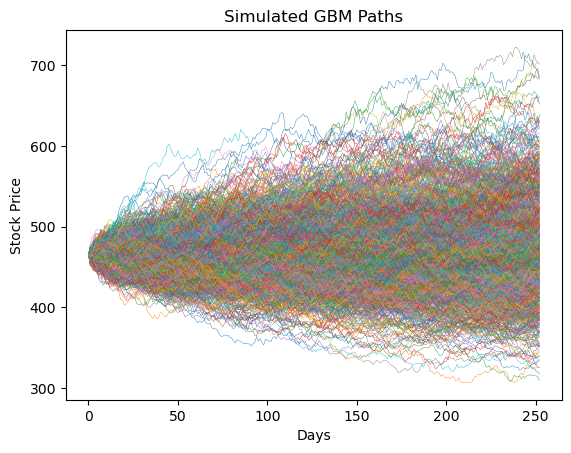

Black-Scholes Price: 28.8581
MC Price: 29.3273
MC Price (antithetic): 28.8812


In [ ]:
# Plot simulated paths
paths = stock_paths(S0, r, sigma, T, n_steps, n_paths)
plt.plot(paths, linewidth=0.3)
plt.title("Simulated GBM Paths")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()

# Compare Monte Carlo (for one run!) vs BS pricing (reduced number of paths for visualization)
bs_price = bs_call_price(S0, K, r, sigma, T)
mc_price = mc_call_price(S0, K, r, sigma, T, n_steps, n_paths)
mc_anti = mc_call_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths)

print(f"Black-Scholes Price: {bs_price:.4f}")
print(f"MC Price: {mc_price:.4f}")
print(f"MC Price (antithetic): {mc_anti:.4f}")

Text(0.5, 1.0, 'Stock Path Distribution')

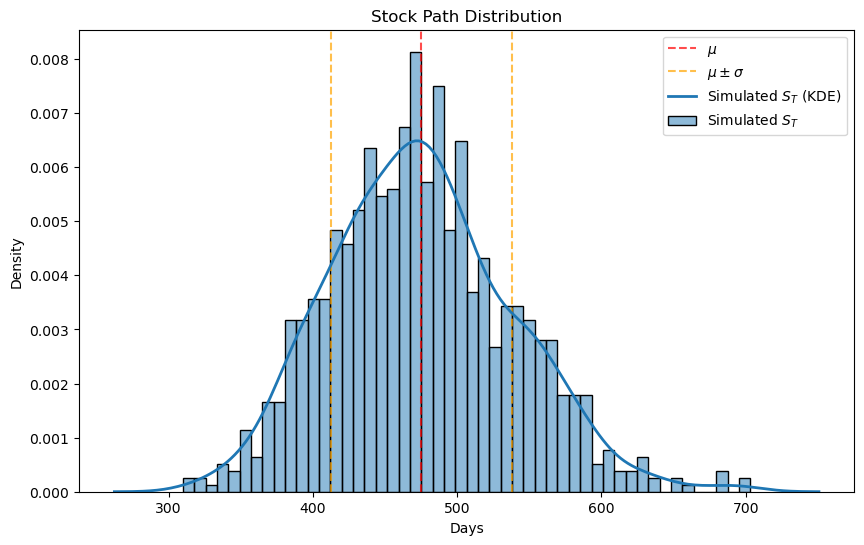

In [8]:
# stock paths distribution should be lognormal
ST = paths[-1, :]
sd = ST.std()
mu = ST.mean()
plt.figure(figsize=(10, 6))
sns.histplot(ST, bins=50, stat="density", alpha=0.5, label="Simulated $S_T$")
plt.axvline(mu, linestyle = "--", c = "red", label = "$\\mu$", alpha = 0.7)
plt.axvline(mu+sd, linestyle = "--", c = "orange", label = "$\\mu \pm \sigma$", alpha = 0.7 )
plt.axvline(mu-sd, linestyle = "--", c = "orange", alpha = 0.7)
sns.kdeplot(ST, label="Simulated $S_T$ (KDE)", linewidth=2)
plt.xlabel("Days")
plt.legend()
plt.title("Stock Path Distribution")

Text(0.5, 1.0, 'Stock Path Distribution')

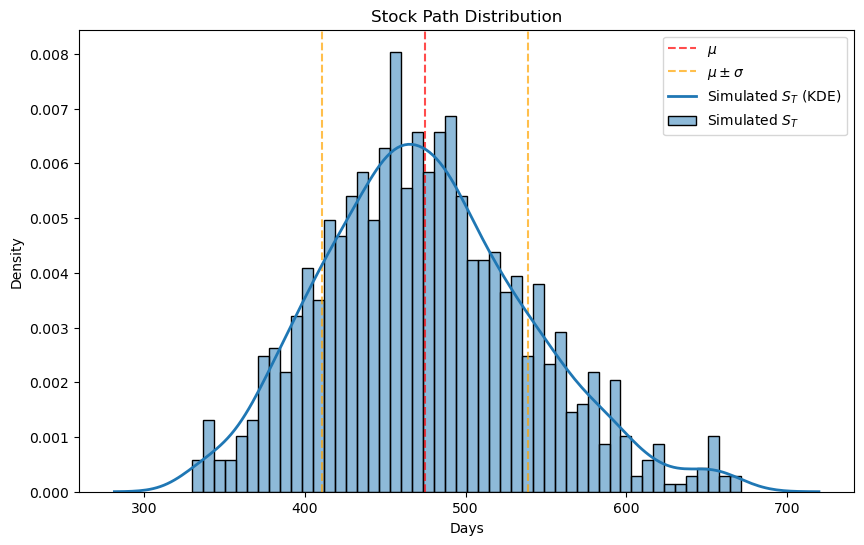

In [9]:
# stock paths distribution should be lognormal
ST_anti = stock_paths_antithetic(S0, r, sigma, T, n_steps, n_paths)[-1,:]
mu_anti = ST_anti.mean()
sd_anti = ST_anti.std()
plt.figure(figsize=(10, 6))
plt.axvline(mu_anti, linestyle = "--", c = "red", label = "$\\mu$", alpha = 0.7)
plt.axvline(mu_anti+sd_anti, linestyle = "--", c = "orange", label = "$\\mu \pm \sigma$", alpha = 0.7 )
plt.axvline(mu_anti-sd_anti, linestyle = "--", c = "orange", alpha = 0.7)
sns.histplot(ST_anti, bins=50, stat="density", alpha=0.5, label="Simulated $S_T$")
sns.kdeplot(ST_anti, label="Simulated $S_T$ (KDE)", linewidth=2)
plt.xlabel("Days")
plt.legend()
plt.title("Stock Path Distribution")

In [10]:
n_simulations = 500  # MC runs

# Get BS price
bs_price = bs_call_price(S0, K, r, sigma, T)
print(f"Black-Scholes Price: {bs_price:.4f}")

# MC estimators
mc_estimates = []
mc_anti_estimates = []
for s in range(n_simulations):
    # Standard MC estimate
    estimate = mc_call_price(S0, K, r, sigma, T, n_steps, n_paths)
    mc_estimates.append(estimate)
    
    # Antithetic MC estimate
    estimate_anti = mc_call_price_antithetic(S0, K, r, sigma, T, n_steps, n_paths)
    mc_anti_estimates.append(estimate_anti)

mc_estimates = np.array(mc_estimates)
mc_anti_estimates = np.array(mc_anti_estimates)
# stats
print("\nStandard MC Estimator Statistics:")
print(f"  Mean:              {mc_estimates.mean():.4f}")
print(f"  Std deviation:     {mc_estimates.std():.4f}")

print("\nAntithetic MC Estimator Statistics:")
print(f"  Mean:              {mc_anti_estimates.mean():.4f}")
print(f"  Std deviation:     {mc_anti_estimates.std():.4f}") # expected lower

Black-Scholes Price: 28.8581

Standard MC Estimator Statistics:
  Mean:              28.9209
  Std deviation:     1.3968

Antithetic MC Estimator Statistics:
  Mean:              28.8733
  Std deviation:     0.8956


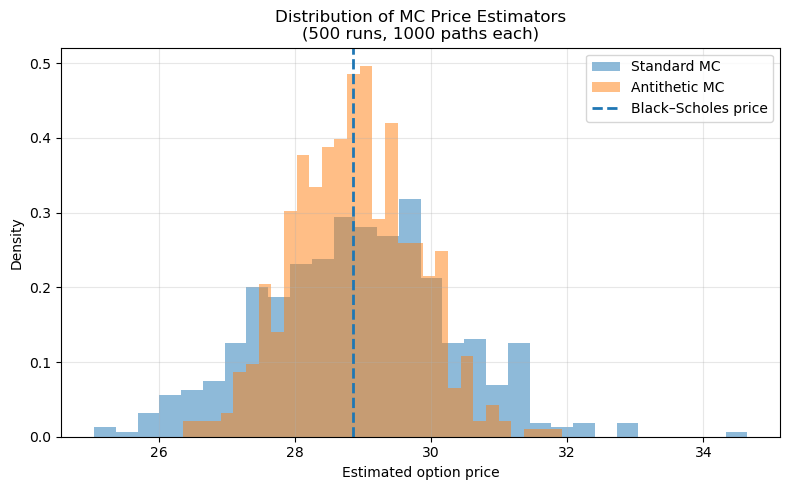

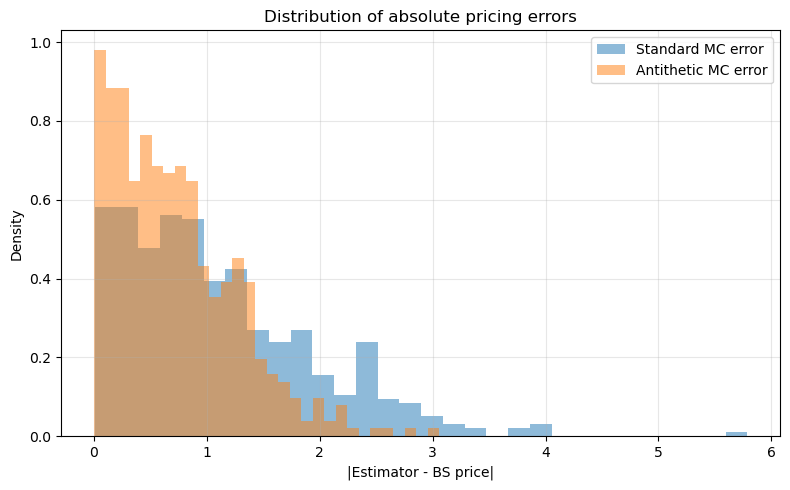

In [11]:
#Plots of the estimator distributions
#This plot shows the distribution of the MC, antithetic sampling estimates together with the theoretical price
plt.figure(figsize=(8,5))
bins = 30

plt.hist(mc_estimates,bins=bins,alpha=0.5,density=True,label='Standard MC')
plt.hist(mc_anti_estimates,bins=bins,alpha=0.5,density=True,label="Antithetic MC")

#Add theoretical price
plt.axvline(bs_price, linestyle='dashed', linewidth=2, label='Black–Scholes price')
plt.title(f'Distribution of MC Price Estimators\n({n_simulations} runs, {n_paths} paths each)')
plt.xlabel('Estimated option price')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#Possible extension is distribution of absolute errors in both estimates
errors_mc = np.abs(mc_estimates- bs_price)
errors_anti = np.abs(mc_anti_estimates - bs_price)

plt.figure(figsize=(8, 5))
plt.hist(errors_mc, bins=bins, alpha=0.5, density=True, label='Standard MC error')
plt.hist(errors_anti, bins=bins, alpha=0.5, density=True, label='Antithetic MC error')

plt.title('Distribution of absolute pricing errors')
plt.xlabel('|Estimator - BS price|')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


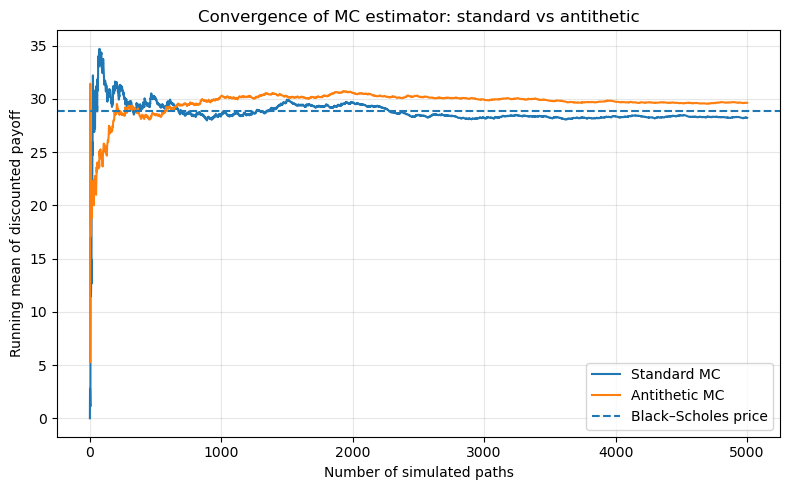

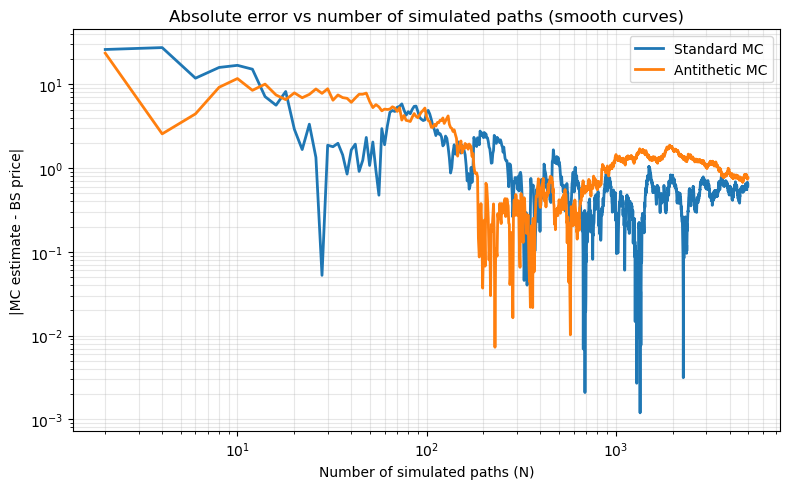

In [ ]:
# Convergence display: how quickly does the Monte Carlo estimator converge to the BS price?

N_pairs = 2500              # number of ANTITHETIC PAIRS
N_std   = 2 * N_pairs       # total paths for standard MC (same total paths as antithetic)

# Standard Monte Carlo
paths_std = stock_paths(S0, r, sigma, T, n_steps, N_std)
ST_std = paths_std[-1, :]
payoff_std = np.maximum(ST_std - K, 0.0)
disc_payoff_std = np.exp(-r * T) * payoff_std
# Running mean as we add more paths incrementally
running_mean_std = np.cumsum(disc_payoff_std) / np.arange(1, N_std + 1)

# Antithetic Monte Carlo
paths_anti = stock_paths_antithetic(S0, r, sigma, T, n_steps, 2 * N_pairs)
ST_anti = paths_anti[-1, :]
payoff_anti = np.maximum(ST_anti - K, 0.0)
# Pair payoffs: first half with second half
payoff_pairs = 0.5 * (payoff_anti[:N_pairs] + payoff_anti[N_pairs:]) 
disc_payoff_pairs = np.exp(-r * T) * payoff_pairs
# Running mean over number of PAIRS (each pair uses 2 paths)
running_mean_anti = np.cumsum(disc_payoff_pairs) / np.arange(1, N_pairs + 1)

# True value
bs_price_ref = bs_call_price(S0, K, r, sigma, T)

# Running means
plt.figure(figsize=(8, 5))
# X-axis for standard: number of paths
x_std = np.arange(1, N_std + 1)
# X-axis for antithetic: number of *underlying paths* (2 per pair)
x_anti = 2 * np.arange(1, N_pairs + 1)
plt.plot(x_std, running_mean_std, label="Standard MC")
plt.plot(x_anti, running_mean_anti, label="Antithetic MC")
plt.axhline(bs_price_ref, linestyle="--", label="Black–Scholes price")
plt.xlabel("Number of simulated paths")
plt.ylabel("Running mean of discounted payoff")
plt.title("Convergence of MC estimator: standard vs antithetic")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
# - Both running means should fluctuate around the BS price and stabilize as N grows.
# - The antithetic line should typically be 'smoother', illustrating lower variance
#   for the same total number of simulated paths.

# Absolute error vs number of simulated paths (smooth lines)
# Compute absolute errors
abs_err_std_full  = np.abs(running_mean_std - bs_price_ref)
abs_err_anti_pairs = np.abs(running_mean_anti - bs_price_ref)
# Same number of underlying paths: 2, 4, 6, ..., 2*N_pairs
n_pairs_index = np.arange(1, N_pairs + 1)
n_paths_pairs = 2 * n_pairs_index
# Match standard MC running-mean indices (0-based)
idx_std_for_pairs = n_paths_pairs - 1
abs_err_std_pairs = abs_err_std_full[idx_std_for_pairs]
abs_err_anti      = abs_err_anti_pairs

# Log log plot
plt.figure(figsize=(8, 5))
plt.loglog(n_paths_pairs, abs_err_std_pairs, label="Standard MC", linewidth=2)
plt.loglog(n_paths_pairs, abs_err_anti,      label="Antithetic MC", linewidth=2)

plt.xlabel("Number of simulated paths (N)")
plt.ylabel("|MC estimate - BS price|")
plt.title("Absolute error vs number of simulated paths (smooth curves)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# Results:
#   Antithetic MC should remain below Standard MC most of the time,
#   demonstrating faster convergence (lower absolute error for the same N).


In [98]:
## TO DO: add maximum/minimum value for error
## TO DO: add tolerance measurement for convergence

In [47]:
# T-tests: are estimators unbiased?
print("T-TESTS (Testing if estimators are unbiased)")
print("H0: Mean of estimator = Black-Scholes price")
print("H1: Mean of estimator ≠ Black-Scholes price\n")

t_stat_std, p_value_std = ttest_1samp(mc_estimates, bs_price)
print("Standard MC:")
print(f"  t-statistic: {t_stat_std:.4f}")
print(f"  p-value:     {p_value_std:.4f}")
if p_value_std > 0.05:
    print(f"  ✓ Fail to reject H0 (estimator is unbiased)")
else:
    print(f"  ✗ Reject H0 (estimator may be biased)")

t_stat_anti, p_value_anti = ttest_1samp(mc_anti_estimates, bs_price)
print("\nAntithetic MC:")
print(f"  t-statistic: {t_stat_anti:.4f}")
print(f"  p-value:     {p_value_anti:.4f}")
if p_value_anti > 0.05:
    print(f"  ✓ Fail to reject H0 (estimator is unbiased)")
else:
    print(f"  ✗ Reject H0 (estimator may be biased)")

# F-test: Variance reduction
print("\nF-TEST (Testing variance reduction)")
print("H0: Var(Standard MC) = Var(Antithetic MC)")
print("H1: Var(Standard MC) > Var(Antithetic MC)\n")

s1_squared = np.var(mc_estimates, ddof=1)
s2_squared = np.var(mc_anti_estimates, ddof=1)

F_stat = s1_squared / s2_squared
df1 = len(mc_estimates) - 1
df2 = len(mc_anti_estimates) - 1

# One-sided test (right tail)
p_value_f = 1 - f.cdf(F_stat, df1, df2)

print(f"Standard MC variance:   {s1_squared:.6f}")
print(f"Antithetic MC variance: {s2_squared:.6f}")
print(f"F-statistic:            {F_stat:.4f}")
print(f"p-value (one-sided):    {p_value_f:.6f}")

variance_reduction = (1 - s2_squared/s1_squared) * 100
print(f"\nVariance reduction: {variance_reduction:.2f}%")

if p_value_f < 0.05:
    print("✓ Reject H0: Antithetic sampling significantly reduces variance")
else:
    print("✗ Fail to reject H0: No significant variance reduction")


T-TESTS (Testing if estimators are unbiased)
H0: Mean of estimator = Black-Scholes price
H1: Mean of estimator ≠ Black-Scholes price

Standard MC:
  t-statistic: -0.0263
  p-value:     0.9791
  ✓ Fail to reject H0 (estimator is unbiased)

Antithetic MC:
  t-statistic: 0.9079
  p-value:     0.3644
  ✓ Fail to reject H0 (estimator is unbiased)

F-TEST (Testing variance reduction)
H0: Var(Standard MC) = Var(Antithetic MC)
H1: Var(Standard MC) > Var(Antithetic MC)

Standard MC variance:   1.664958
Antithetic MC variance: 0.821359
F-statistic:            2.0271
p-value (one-sided):    0.000000

Variance reduction: 50.67%
✓ Reject H0: Antithetic sampling significantly reduces variance


In [12]:
def simulate_delta_hedging(price_paths, K, r, sigma, T):
    """
    Simulate delta hedging.
    price_paths : simulated stock price paths
        Simulated stock price paths
    K : strike price
    r : risk-free rate
    sigma : Volatility used for hedging
    T : Time to maturity
    """
    n_steps, n_paths = price_paths.shape[0] - 1, price_paths.shape[1]
    dt = T / n_steps
    
    # store results
    hedge_errors = np.zeros(n_paths)
    total_trades = np.zeros(n_paths)
    
    for j in range(n_paths):
        S_path = price_paths[:, j] # for every path
        
        # at t=0 sell option at at BS price
        option_price = bs_call_price(S_path[0], K, r, sigma, T)
        cash = option_price
        stock_pos = 0.0
        
        # over the life of the option: delta hedge
        for i in range(n_steps):
            t = i * dt
            tau = T - t
            
            # cash earns interest
            cash *= np.exp(r * dt)
            
            # get delta target
            delta_target = bs_delta(S_path[i], K, r, sigma, tau)
            # execute trade
            trade = delta_target - stock_pos
            # update position
            cash -= trade * S_path[i]  # pay for stock
            stock_pos = delta_target
            # track total trades
            total_trades[j] += abs(trade)

        # at maturity... settle
        ST = S_path[-1]
        payoff = max(ST - K, 0.0)
        
        # Liquidate stock position
        liquidation_value = stock_pos * ST
        cash += liquidation_value

        # get final profit/loss
        hedge_errors[j] = cash - payoff
        
    return hedge_errors

In [16]:
# Scenario 1: Perfect Hedging 
# Simulate stock price paths using antithetic MC
price_paths = stock_paths_antithetic(S0, r, sigma, T, n_steps, n_paths)
errors = simulate_delta_hedging(price_paths, K, r, sigma, T)

Hedging Error Statistics:
  Mean error:            0.0377
  Std deviation:         1.3300
  Min error:            -5.9515
  Max error:             4.4037


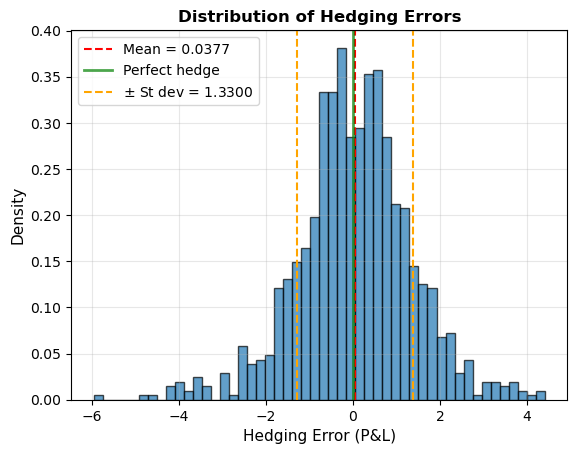

In [63]:
print(f"Hedging Error Statistics:")
print(f"  Mean error:        {errors.mean():>10.4f}")
print(f"  Std deviation:     {errors.std():>10.4f}")
print(f"  Min error:         {errors.min():>10.4f}")
print(f"  Max error:         {errors.max():>10.4f}") 

plt.hist(errors, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(errors.mean(), color='red', linestyle='--', label=f'Mean = {errors.mean():.4f}')
plt.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Perfect hedge')
plt.axvline(errors.mean() + errors.std(), color='orange', linestyle='--', label=f'$\pm$ St dev = {errors.std():.4f}')
plt.axvline(errors.mean() - errors.std(), color='orange', linestyle='--')
plt.xlabel('Hedging Error (P&L)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Distribution of Hedging Errors', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

In [13]:
# Add M/M/1 queue to model execution delays 
# when the seller want to rebalance his position => send order to market (arrival rate) => process order sequentially (service rate)

class MM1Queue:
    def __init__(self, arrival_rate, service_rate):
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        
        # Queue stability check
        self.rho = arrival_rate / service_rate  # Utilization
        if self.rho >= 1:
            raise Exception("Queue unstable")
    
    def generate_service_time(self):
        return np.random.exponential(1.0 / self.service_rate)
    
    def get_queue_stats(self): # get M/M/1 statistics
        rho = self.rho
        return {
            'utilization': rho,
            'avg_queue_length': rho / (1 - rho),
            'avg_time_in_system': 1 / (self.service_rate - self.arrival_rate),
            'avg_waiting_time': rho / (self.service_rate - self.arrival_rate)
        }

In [14]:
# Re run delta hedging with queueing system
def simulate_delta_hedging_MM1(price_paths, K, r, sigma, T, rebalance_threshold=None, use_mm1_queue=False, mm1_arrival_rate = None, mm1_service_rate=None):
    """
    Simulate delta hedging with M/M/1 queue for execution delays
    """
    n_steps, n_paths = price_paths.shape[0] - 1, price_paths.shape[1]
    dt = T / n_steps
    
    # Storage for results
    hedge_errors = np.zeros(n_paths)
    total_trades = np.zeros(n_paths)
    execution_delays = np.zeros(n_paths)
    
    # Iinitialize mm1
    mm1_queue = None
    if use_mm1_queue:
        mm1_queue = MM1Queue(mm1_arrival_rate, mm1_service_rate)
        stats = mm1_queue.get_queue_stats()
        print(f"\nM/M/1 Queue Statistics:")
        print(f"  Utilization:{stats['utilization']:.3f}")
        print(f"  Avg queue length:{stats['avg_queue_length']:.3f} orders")
        print(f"  Avg time in system:{stats['avg_time_in_system']:.6f}")
        print(f"  Avg waiting time:{stats['avg_waiting_time']:.6f}")
    
    for j in range(n_paths):
        # as above
        S_path = price_paths[:, j] 
        option_price = bs_call_price(S_path[0], K, r, sigma, T)
        cash = option_price
        stock_pos = 0.0
        
        # track pending orders in queue
        pending_order = None  # (execution_time, delta_target, decision_price)
        total_delay = 0.0
        num_trades = 0
        
        for i in range(n_steps):
            t = i * dt
            tau = T - t
            cash *= np.exp(r * dt)
            if pending_order is not None: # process order
                exec_time, delta_target_pending, decision_price = pending_order
                if t >= exec_time:
                    # order exectures at current price!
                    trade = delta_target_pending - stock_pos
                    execution_price = S_path[i]
                    # update positions
                    cash -= trade * execution_price
                    stock_pos = delta_target_pending
                    # track statistics
                    total_trades[j] += abs(trade)
                    total_delay += (exec_time - (exec_time - (t - exec_time))) 
                    num_trades += 1 
                    # clear pending order
                    pending_order = None
            # calculate target delta at current time
            delta_target = bs_delta(S_path[i], K, r, sigma, tau)
            # decide whether to place new rebalancing order
            should_rebalance = pending_order is None  # only if no pending order
            
            if should_rebalance and rebalance_threshold is not None:
                if abs(delta_target - stock_pos) < rebalance_threshold:
                    should_rebalance = False
            
            # olace order if needed
            if should_rebalance and abs(delta_target - stock_pos) > 1e-6:
                if use_mm1_queue and mm1_queue is not None:
                    # Generate execution delay from M/M/1 queue
                    delay = mm1_queue.generate_service_time()
                    execution_time = t + delay
                    # Order won't execute if it goes beyond maturity
                    if execution_time < T:
                        pending_order = (execution_time, delta_target, S_path[i])
                else:
                    # Immediate execution (no queue)
                    trade = delta_target - stock_pos
                    # Update positions
                    cash -= trade * S_path[i]
                    stock_pos = delta_target          
                    # Track statistics
                    total_trades[j] += abs(trade)
        # Record average delay
        if num_trades > 0:
            execution_delays[j] = total_delay / num_trades
        
        # Settlement at maturity
        ST = S_path[-1]
        payoff = max(ST - K, 0.0)
        
        # Liquidate stock position (assume instant at maturity)
        liquidation_value = stock_pos * ST
        cash += liquidation_value
        # Final P&L
        hedge_errors[j] = cash - payoff
        
    results = {'hedge_errors': hedge_errors, 'total_trades': total_trades}
    
    if use_mm1_queue:
        results['execution_delays'] = execution_delays
    
    return results

In [ ]:
# first implementation
service_rate = 200
arrival_rate = 0.5*252


results_mm1 = simulate_delta_hedging_MM1(price_paths, K, r, sigma, T, rebalance_threshold=0.01, use_mm1_queue=True,
        mm1_arrival_rate=arrival_rate,
        mm1_service_rate=service_rate
    )


M/M/1 Queue Statistics:
  Utilization:0.630
  Avg queue length:1.703 orders
  Avg time in system:0.013514
  Avg waiting time:0.008514


Hedging Error Statistics:
  Mean error:        $    0.0708
  Std deviation:     $    4.4577
  Min error:         $  -18.4398
  Max error:         $   19.3620


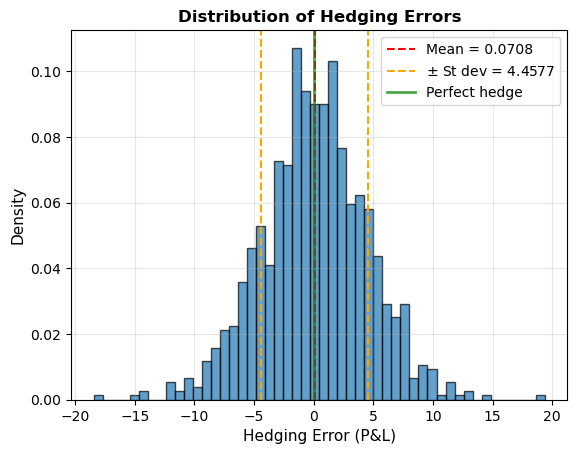

In [18]:
errors_mm1 = results_mm1['hedge_errors']
trades_mm1 = results_mm1['total_trades']

print(f"Hedging Error Statistics:")
print(f"  Mean error:        ${errors_mm1.mean():>10.4f}")
print(f"  Std deviation:     ${errors_mm1.std():>10.4f}")
print(f"  Min error:         ${errors_mm1.min():>10.4f}")
print(f"  Max error:         ${errors_mm1.max():>10.4f}")


plt.hist(errors_mm1, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(errors_mm1.mean(), color='red', linestyle='--', label=f'Mean = {errors_mm1.mean():.4f}')
plt.axvline(errors_mm1.mean() + errors_mm1.std(), color='orange', linestyle='--', label=f'$\pm$ St dev = {errors_mm1.std():.4f}')
plt.axvline(errors_mm1.mean() - errors_mm1.std(), color='orange', linestyle='--')
plt.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Perfect hedge')
plt.xlabel('Hedging Error (P&L)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Distribution of Hedging Errors', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)


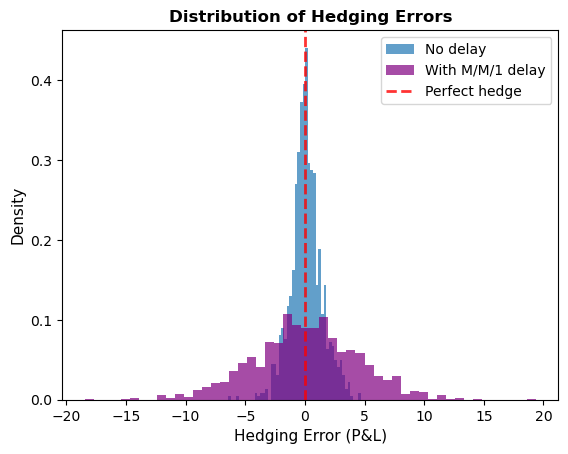

In [19]:
# Overlay of hedging errors distribution 
plt.hist(errors, bins=50, density=True, alpha=0.7, label="No delay")
plt.hist(errors_mm1, bins=50, density=True, color= "purple", alpha=0.7, label="With M/M/1 delay")
plt.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Perfect hedge')
plt.xlabel('Hedging Error (P&L)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Distribution of Hedging Errors', fontsize=12, fontweight='bold')
plt.legend()


In [ ]:
# H0: mean(errors) = 0 for both with and without delay
# This tests whether the queue makes hedging errors systematically positive/negative.

# One-sample t-test: compare errors with mean = 0
t_stat_delay, p_value_delay = ttest_1samp(errors_mm1, popmean=0.0)

print("=== t-test: mean hedging error with delays ===")
print(f"Sample mean (delay): {errors_mm1.mean():.6f}")
print(f"Sample std  (delay): {errors_mm1.std(ddof=1):.6f}")
print(f"t-statistic:         {t_stat_delay:.4f}")
print(f"p-value:             {p_value_delay:.4f}")

t_stat_no_delay, p_value_no_delay = ttest_1samp(errors, popmean=0.0)
print("\n=== t-test: mean hedging error without delays (reference) ===")
print(f"Sample mean (no delay): {errors.mean():.6f}")
print(f"Sample std  (no delay): {errors.std(ddof=1):.6f}")
print(f"t-statistic:           {t_stat_no_delay:.4f}")
print(f"p-value:               {p_value_no_delay:.4f}")


# One-sided test for mean(with delay) > mean(no delay)
t_stat_d_vs_nod, p_value_d_vs_nod = ttest_ind(errors_mm1, errors, equal_var=False, alternative="greater")

print("\n=== One-sided Welch t-test: mean(delay) > mean(no delay) ===")
print(f"Mean(delay):       {errors_mm1.mean():.6f}")
print(f"Mean(no delay):    {errors.mean():.6f}")
print(f"Difference:        {errors_mm1.mean() - errors.mean():.6f}")
print(f"t-statistic:       {t_stat_d_vs_nod:.4f}")
print(f"one-sided p-value: {p_value_d_vs_nod :.4f}")


# F-test for equality of variances
# H0: var(with delay) = var(no delay)
# This checks whether execution delays increase the risk (variance) of hedging errors.
# Sample variances with Bessel correction (ddof=1)

var_no_delay = np.var(errors, ddof=1)
var_delay    = np.var(errors_mm1, ddof=1)

df_no_delay = len(errors) - 1
df_delay    = len(errors_mm1) - 1

F_stat = var_delay / var_no_delay

# One-sided test (right tail)
p_value = 1 - f.cdf(F_stat, df_no_delay, df_delay)

print("\n=== F-test: variance with delays vs without delays ===")
print(f"var(no delay) = {var_no_delay:.6e}")
print(f"var(delay)    = {var_delay:.6e}")
print(f"F-statistic   = {F_stat:.4f}")
print(f"df (delay)    = {df_delay}")
print(f"df (no delay) = {df_no_delay}")
print(f"p-value       = {p_value:.4f}")



=== t-test: mean hedging error with delays ===
Sample mean (delay): 0.070761
Sample std  (delay): 4.459948
t-statistic:         0.5017
p-value:             0.6160

=== t-test: mean hedging error without delays (reference) ===
Sample mean (no delay): 0.101406
Sample std  (no delay): 1.324477
t-statistic:           2.4211
p-value:               0.0156

=== One-sided Welch t-test: mean(delay) > mean(no delay) ===
Mean(delay):       0.070761
Mean(no delay):    0.101406
Difference:        -0.030645
t-statistic:       -0.2083
one-sided p-value: 0.5825

=== F-test: variance with delays vs without delays ===
var(no delay) = 1.754240e+00
var(delay)    = 1.989113e+01
F-statistic   = 11.3389
df (delay)    = 999
df (no delay) = 999
p-value       = 0.0000


In [38]:
# Add model extension 1: Levy jumps
def simulate_merton_jump_diffusion_paths(
    S0, r, sigma, lam, mJ, sJ, T, M, N_paths, seed=None
):
    """
    Simulate Merton jump–diffusion paths under risk-neutral measure:

    log S_t = log S_0 + (r - 0.5 sigma^2 - lam * kappa) t
              + sigma W_t + sum_{k=1}^{N_t} Y_k

    where N_t ~ Poisson(lam t), Y_k ~ N(mJ, sJ^2).
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / M
    sqrt_dt = np.sqrt(dt)

    kappa = np.exp(mJ + 0.5 * sJ**2) - 1.0  # E[e^Y - 1]
    logS = np.full(N_paths, np.log(S0))
    S = np.empty((N_paths, M + 1))
    S[:, 0] = S0

    for k in range(M):
        # Brownian part
        Z = np.random.randn(N_paths)

        # Number of jumps in (t_k, t_{k+1}]
        N_jumps = np.random.poisson(lam * dt, size=N_paths)

        # Sum of jump sizes for each path
        jump_sum = np.zeros(N_paths)
        for i in range(N_paths):
            if N_jumps[i] > 0:
                jump_sum[i] = np.random.normal(mJ, sJ, size=N_jumps[i]).sum()

        logS += ((r - 0.5 * sigma**2 - lam * kappa) * dt
                 + sigma * sqrt_dt * Z
                 + jump_sum)
        S[:, k+1] = np.exp(logS)

    return S

Text(0.5, 0, '$S_T$')

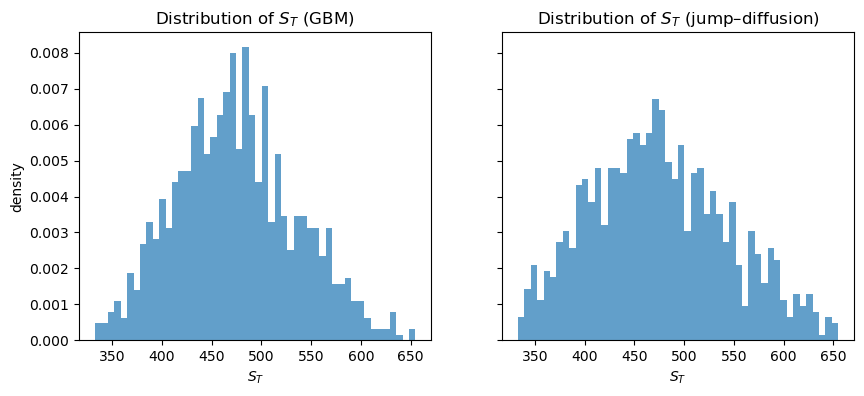

In [ ]:
# Jump parameters for Merton model
lam = 0.5        # expected <1 jump per year
mJ = -0.05       # mean jump in log-price 
sJ = 0.1         # std of jump in log-price

jd_paths = simulate_merton_jump_diffusion_paths(S0, r, sigma, lam, mJ, sJ, T, n_steps, n_paths)
S_T_jd = jd_paths[:, -1]

all_ST = np.concatenate([ST, S_T_jd])
xmin, xmax = np.percentile(all_ST, [1, 99])  # cut extreme outliers just for plotting

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# GBM
axes[0].hist(ST, bins=50, density=True, range=(xmin, xmax), alpha=0.7)
axes[0].set_title("Distribution of $S_T$ (GBM)")
axes[0].set_xlabel("$S_T$")
axes[0].set_ylabel("density")

# Jump–diffusion
axes[1].hist(S_T_jd, bins=50, density=True, range=(xmin, xmax), alpha=0.7)
axes[1].set_title("Distribution of $S_T$ (jump–diffusion)")
axes[1].set_xlabel("$S_T$")

In [78]:
def mc_call_price_jumps(paths, K, r, T):
    """
    Given simulated paths (shape N_paths x (M+1)), estimate call price
    by Monte Carlo under risk-neutral measure.
    """
    ST = paths[:, -1]
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * payoff.mean()


In [ ]:
# Compared with what we obtained previously
print(f"Analytic BS call price: {bs_price:.4f}")

print(f"MC call price under GBM: {mc_estimates.mean():.4f} +/- {1.96*mc_estimates.std():.4f}")

jd_estimate = []
for s in range(n_simulations):
    jd_paths_sim = simulate_merton_jump_diffusion_paths(
        S0, r, sigma, lam, mJ, sJ, T, n_steps, n_paths)
    price_jd_mc = mc_call_price_jumps(jd_paths_sim, K, r, T)
    jd_estimate.append(price_jd_mc)

jd_estimates = np.array([jd_estimate])
print(f"MC call price under jump–diffusion: {jd_estimates.mean():.4f} "
          f"+/- {1.96*jd_estimates.std():.4f}")


Analytic BS call price: 28.8581
MC call price under GBM: 28.9209 +/- 2.7377
MC call price under jump–diffusion: 32.3115 +/- 2.7633


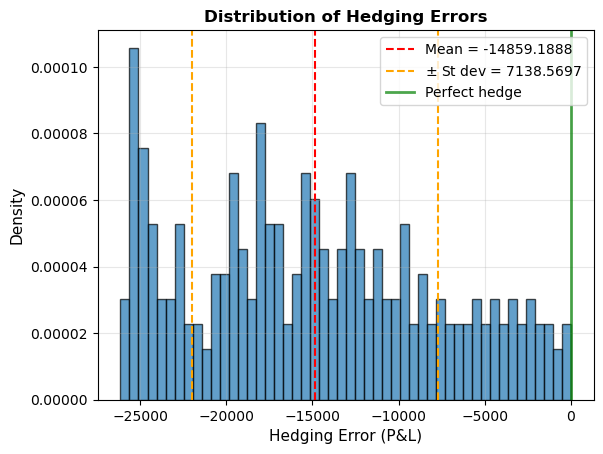

In [96]:
errors_jd  = simulate_delta_hedging(jd_paths, K, r, sigma, T)
plt.hist(errors_jd, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(errors_jd.mean(), color='red', linestyle='--', label=f'Mean = {errors_jd.mean():.4f}')
plt.axvline(errors_jd.mean() + errors_jd.std(), color='orange', linestyle='--', label=f'$\pm$ St dev = {errors_jd.std():.4f}')
plt.axvline(errors_jd.mean() - errors_jd.std(), color='orange', linestyle='--')
plt.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Perfect hedge')
plt.xlabel('Hedging Error (P&L)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Distribution of Hedging Errors', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

In [80]:
def summarize_errors(name, errs):
        mean = errs.mean()
        std  = errs.std(ddof=1)
        q05, q50, q95 = np.quantile(errs, [0.05, 0.5, 0.95])
        print(f"\n{name} hedging error summary:")
        print(f"  mean      = {mean:.6f}")
        print(f"  std       = {std:.6f}")
        print(f"  5% quant  = {q05:.6f}")
        print(f"  median    = {q50:.6f}")
        print(f"  95% quant = {q95:.6f}")

summarize_errors("GBM (correct model)", errors)
summarize_errors("Jump–diffusion (model mis-specified)", errors_jd)


GBM (correct model) hedging error summary:
  mean      = 0.101406
  std       = 1.324477
  5% quant  = -2.019482
  median    = 0.059073
  95% quant = 2.411241

Jump–diffusion (model mis-specified) hedging error summary:
  mean      = -14859.188797
  std       = 7152.719495
  5% quant  = -25216.905597
  median    = -15288.331957
  95% quant = -2322.516126


In [82]:
def simulate_markov_vol_paths(
    S0,
    r,
    sigmas,          # array-like, e.g. [sigma_L, sigma_H]
    P,               # 2x2 transition matrix for regimes
    T,
    M,
    N_paths,
    init_state=0,    # 0 = low, 1 = high
    seed=None
):
    """
    Simulate GBM paths with Markov-switching volatility.

    Regime X_k in {0,1} is a Markov chain with transition matrix P.
    Given regime X_k, the volatility in [t_k, t_{k+1}] is sigmas[X_k],
    and the price update is:

        S_{k+1} = S_k * exp((r - 0.5*sigma_k^2)*dt + sigma_k*sqrt(dt)*Z_k).

    Returns:
        S: array of shape (N_paths, M+1) with simulated prices
        X: array of shape (N_paths, M+1) with regime indices
    """
    if seed is not None:
        np.random.seed(seed)

    sigmas = np.asarray(sigmas)
    P = np.asarray(P)
    dt = T / M
    sqrt_dt = np.sqrt(dt)

    S = np.empty((N_paths, M + 1))
    X = np.empty((N_paths, M + 1), dtype=int)

    S[:, 0] = S0
    X[:, 0] = init_state  # start all paths in same regime for simplicity

    for k in range(M):
        # Determine volatility for this step from current regime
        sigma_k = sigmas[X[:, k]]  # shape (N_paths,)

        # Brownian shocks
        Z = np.random.randn(N_paths)

        # Price update
        S[:, k+1] = S[:, k] * np.exp(
            (r - 0.5 * sigma_k**2) * dt + sigma_k * sqrt_dt * Z
        )

        # Regime update: sample X_{k+1} from P[X_k, :]
        U = np.random.rand(N_paths)
        # For 2-state case: threshold at P[i,0]
        p00 = P[0, 0]
        p11 = P[1, 1]

        # Vectorised update for two states
        next_state = np.empty(N_paths, dtype=int)
        # if currently in state 0
        idx0 = (X[:, k] == 0)
        next_state[idx0] = (U[idx0] > p00).astype(int)
        # if currently in state 1
        idx1 = ~idx0
        next_state[idx1] = (U[idx1] <= p11).astype(int)

        X[:, k+1] = next_state

    return S, X


In [ ]:
# Volatility levels
sigma_L = 0.15   # normal market
sigma_H = 0.25   # elevated sigma but not crisis

# Transition matrix 
P = np.array([[0.98, 0.02],   # Stay normal 98% 
              [0.05, 0.95]])  # Stay elevated 95% 

sigmas = [sigma_L, sigma_H]
prices_markov = []
for s in range(n_simulations):
    markov_paths, markov_states = simulate_markov_vol_paths(
        S0, r, sigmas, P, T, n_steps, n_paths, init_state=0)

    price_markov_mc = mc_call_price_jumps(
        markov_paths, K, r, T
    )
    prices_markov.append(price_markov_mc)

prices_markov_arr = np.array([prices_markov])

print(f"\nMC call price under Markov-switching volatility: "
          f"{prices_markov_arr.mean():.4f} +/- {1.96*prices_markov_arr.std():.4f}")

errors_markov = simulate_delta_hedging(markov_paths, K, r, sigma, T)

summarize_errors("GBM (correct model)", errors)
summarize_errors("Markov-switching vol (model mis-specified)",
                     errors_markov)




MC call price under Markov-switching volatility: 38.0834 +/- 3.6340

GBM (correct model) hedging error summary:
  mean      = 0.101406
  std       = 1.324477
  5% quant  = -2.019482
  median    = 0.059073
  95% quant = 2.411241

Markov-switching vol (model mis-specified) hedging error summary:
  mean      = -18124.232674
  std       = 8768.533186
  5% quant  = -30241.522962
  median    = -19444.293133
  95% quant = -3092.270477


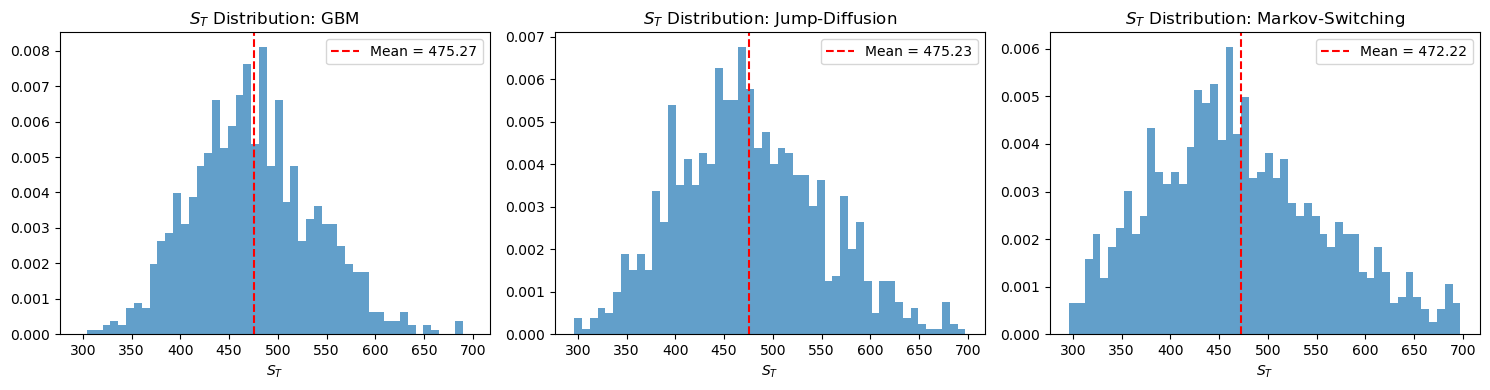

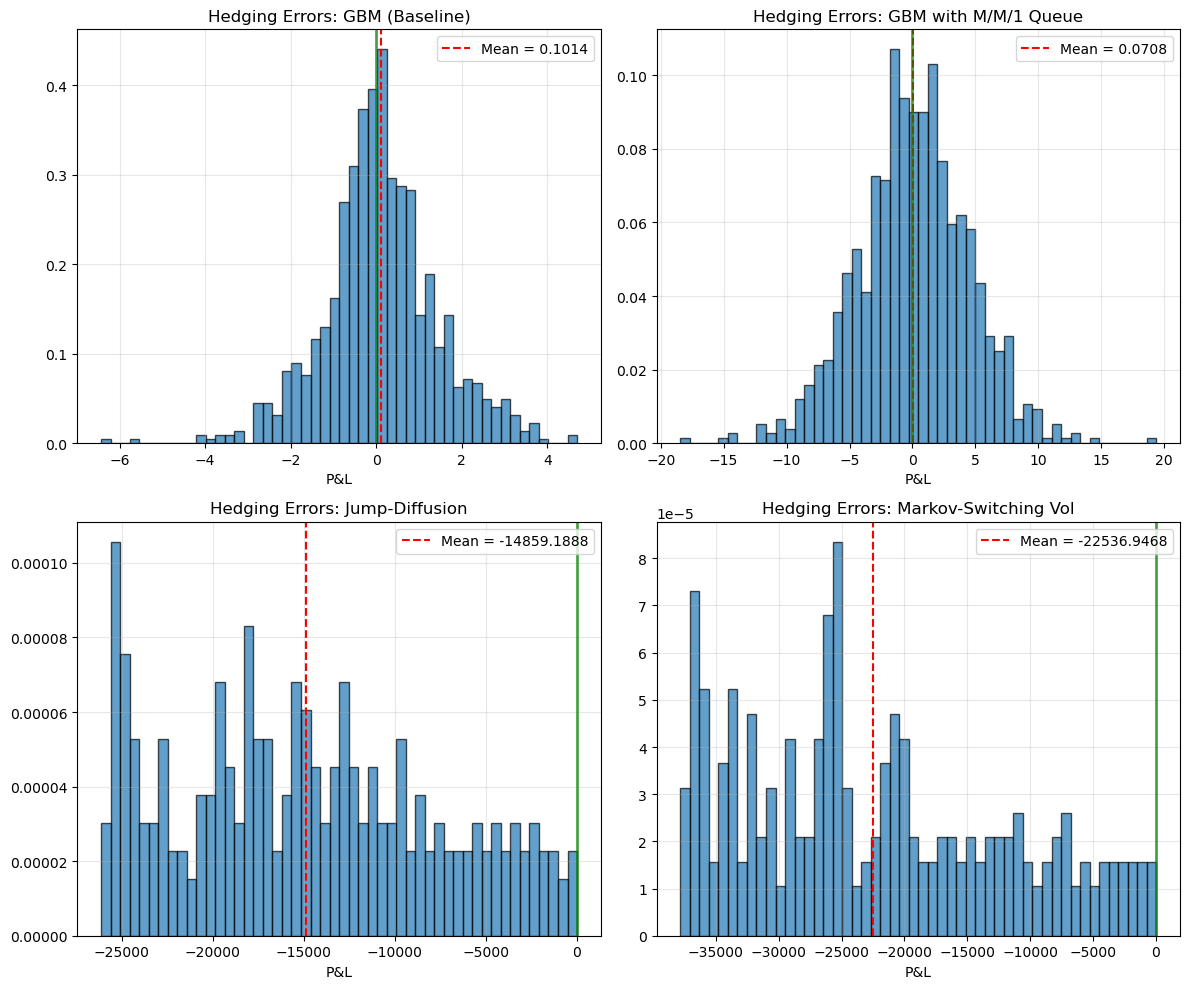

In [ ]:
# Final plots
# Distribution comparison for S_T across all models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
all_ST = np.concatenate([ST, S_T_jd, markov_paths[:, -1]])
xmin, xmax = np.percentile(all_ST, [1, 99])

for ax, data, title in zip(axes, 
                            [ST, S_T_jd, markov_paths[:, -1]],
                            ['GBM', 'Jump-Diffusion', 'Markov-Switching']):
    ax.hist(data, bins=50, density=True, range=(xmin, xmax), alpha=0.7)
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean = {data.mean():.2f}')
    ax.set_title(f'$S_T$ Distribution: {title}')
    ax.set_xlabel('$S_T$')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Hedging errors comparison across all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

error_data = [
    (errors, 'GBM (Baseline)'),
    (errors_mm1, 'GBM with M/M/1 Queue'),
    (errors_jd, 'Jump-Diffusion'),
    (errors_markov, 'Markov-Switching Vol')
]

for ax, (errs, label) in zip(axes, error_data):
    ax.hist(errs, bins=50, density=True, alpha=0.7, edgecolor='black')
    ax.axvline(errs.mean(), color='red', linestyle='--', 
               label=f'Mean = {errs.mean():.4f}')
    ax.axvline(0, color='green', linestyle='-', linewidth=2, alpha=0.7)
    ax.set_title(f'Hedging Errors: {label}')
    ax.set_xlabel('P&L')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

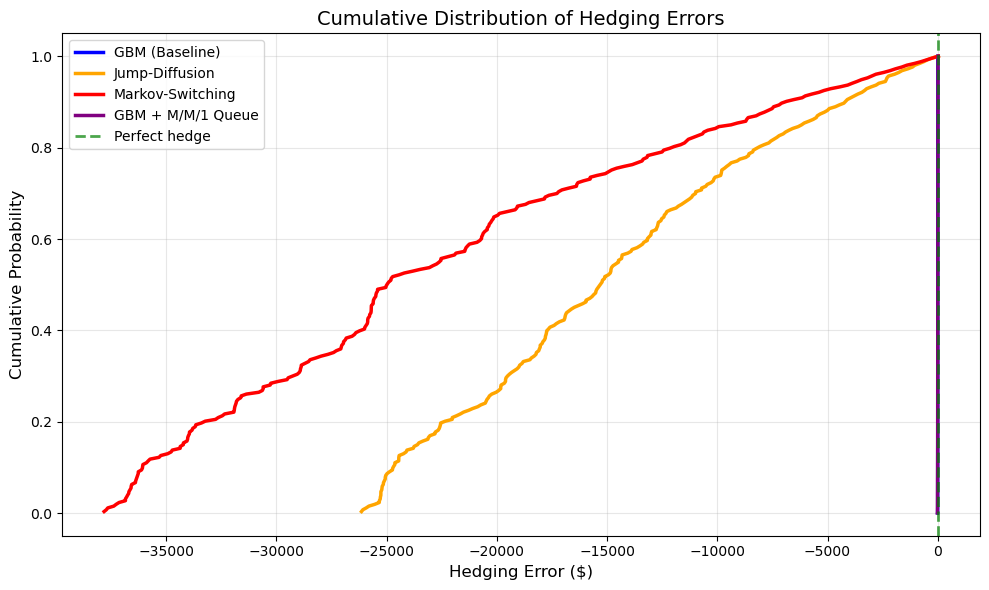

In [ ]:
# see  what % of paths lose x amount
plt.figure(figsize=(10, 6))

models = [
    (errors, 'GBM (Baseline)', 'blue'),
    (errors_jd, 'Jump-Diffusion', 'orange'),
    (errors_markov, 'Markov-Switching', 'red'),
    (errors_mm1, 'GBM + M/M/1 Queue', 'purple')
]

for error_data, label, color in models:
    # Sort data for CDF
    sorted_errors = np.sort(error_data)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    
    plt.plot(sorted_errors, cdf, linewidth=2.5, label=label, color=color)


plt.axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Perfect hedge')

plt.xlabel('Hedging Error ($)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution of Hedging Errors', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()